Potting Data Analysis - New Routine
===================================

This notebook will contain analysis of the data saved in logfiles by the new module potting routine.

First, one must prepare the datafiles.
  1. Log into the t3
  2. execute the following command to create an archive of all potting data 
      ```sh
      zip -uj Potting_Logs.zip /home/dominguez/cfangmeier/elog_git/logbooks/SiLab_Logbook/*/*_Config-*-*-*.zip
      ```
  3. Copy Potting_Logs.zip into the same directory as this notebook
  4. Run the script to convert the logfiles to JSON
     ```sh
     ./PottingLog2JSON.py Potting_Logs.zip
     ```

Alternatively, You can just run the pre-prepared script to automate these steps. Note that you must give the script your t3 username as the first argument so it can execute the scp and ssh commands appropriately.

After running the above, the resulting json can be read in and processed.

In [1]:
%matplotlib notebook
from IPython.display import Markdown, display_markdown
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import itertools
import collections
import json
import Quaternion
from datetime import datetime

plt.style.use('fivethirtyeight')
plt_cols = itertools.cycle([col['color'] for col in plt.rcParams['axes.prop_cycle']._left])
plt.rcParams['figure.figsize'] = [12,8]

In [2]:
dec = json.JSONDecoder()
with open('Potting_Logs.json','r') as f:
    modules = dec.decode(f.read())
modules = {id_: data['potting'] for id_, data in modules.items() if 'potting' in data}

In [3]:
def net_phi(quat):
    quat = [float(q) for q in quat]
    quat = Quaternion.Quat(quat)
    v = np.array([1,0,0])
    v = quat.transform @ v
    return np.arctan2(v[1],v[0]) * 180/np.pi

ss = ['|   | Session ID | Module ID | Operator | Date | Time (min) | Chuck | Slot | Offset ($\mu$m) | $\phi_{HDI}$ | $\phi_{BBM}$ | $\phi_{net}$ | 4cm*$\sin(\phi_{net})$ ($\mu$m)|',
      '|---|------------|-----------|----------|------|-----------:|------:|-----:|----------------:|-------------:|-------------:|-------------:|--------------------------------|']
sorted_keys = sorted(modules, key=lambda k: modules[k]['source_file'])
for i, module_id in enumerate(sorted_keys):
    module = modules[module_id]
    operator = module.get('operator_name','n/a').title()
    try:
        date = module['date']
    except Exception:
        date = "N/A"
    time = module.get('time',0)
    session_id = module['source_file']
    chuck = int(module.get('chuck','N/A'))
    slot = int(module.get('slot', 'N/A'))
    bbm_center = [float(x) for x in module['BBM_center']][:2]
    hdi_center = [float(x) for x in module['HDI_center']][:2]
    offset = sum((x-y)**2 for x,y in zip(bbm_center, hdi_center))**.5
    offset *= 1000
    rot_bbm = net_phi(module['BBM_orient'])
    rot_hdi = net_phi(module['HDI_orient'])
    rot_net = abs(rot_bbm - rot_hdi)
    edge_delta = 4*10000*np.sin(rot_net * (np.pi/180))
    s = ("|{i}|{session_id}|{module_id}|{op}|{date}|{time}|{chuck:02d}|{slot:02d}|{offset:.03f}"
         "|{rot_hdi:.03f}°|{rot_bbm:.03f}°|{rot_net:.03f}°|{edge_delta:.03f}|")
    s = s.format(i=i+1, session_id=session_id, module_id=module_id, op=operator, date=date, time=time,
                 chuck=chuck, slot=slot, offset=offset, rot_hdi=rot_hdi,
                 rot_bbm=rot_bbm, rot_net=rot_net, edge_delta=edge_delta)
    ss.append(s)
m = Markdown('\n'.join(ss))

<IPython.core.display.Javascript object>


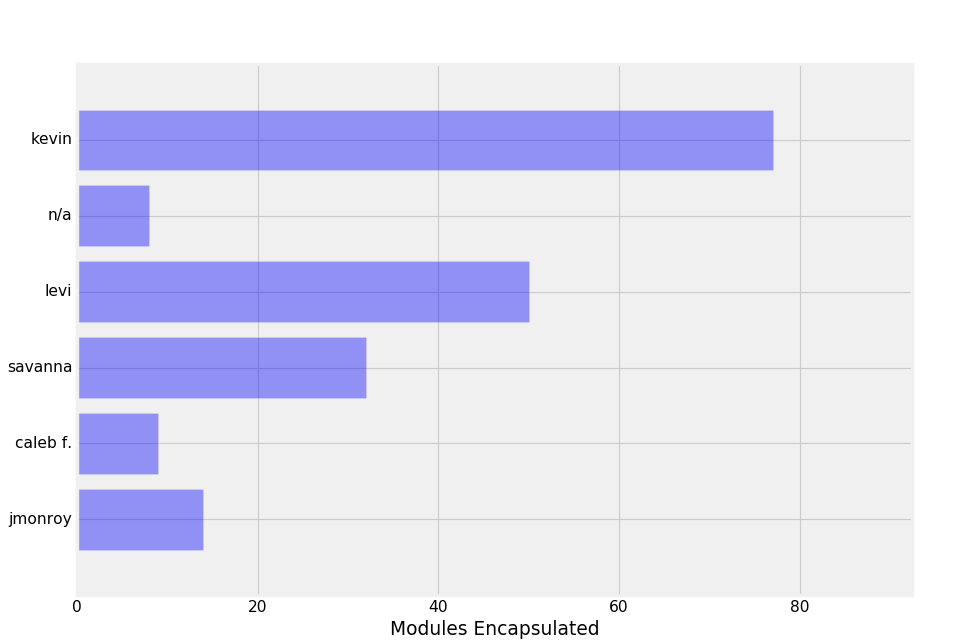

|   | Session ID | Module ID | Operator | Date | Time (min) | Chuck | Slot | Offset ($\mu$m) | $\phi_{HDI}$ | $\phi_{BBM}$ | $\phi_{net}$ | 4cm*$\sin(\phi_{net})$ ($\mu$m)|
|---|------------|-----------|----------|------|-----------:|------:|-----:|----------------:|-------------:|-------------:|-------------:|--------------------------------|
|1|2016_03_30-14_51-000|M-K-2-43|N/A|30/03/2016|26|02|02|16.554|-0.312°|-0.147°|0.165°|115.443|
|2|2016_03_30-14_51-000|M-K-2-35|N/A|30/03/2016|26|02|01|27.168|-0.417°|-0.228°|0.189°|131.761|
|3|2016_03_30-16_09-000|M-K-2-34|N/A|30/03/2016|25|02|01|22.060|-0.275°|-0.207°|0.069°|48.050|
|4|2016_03_30-16_09-000|M-K-2-42|N/A|30/03/2016|25|02|02|38.821|-0.350°|-0.165°|0.185°|129.213|
|5|2016_03_31-15_21-000|M-L-4-07|N/A|31/03/2016|39|02|03|43.366|-0.098°|0.010°|0.108°|75.162|
|6|2016_03_31-16_51-000|M-L-4-29|N/A|31/03/2016|33|02|01|18.969|-0.176°|0.016°|0.192°|134.077|
|7|2016_03_31-17_39-000|M-L-4-40|N/A|31/03/2016|28|02|02|31.480|-0.168°|0.050°|0.218°|152.039|
|8|2016_04_01-10_26-000|M-L-4-50|N/A|01/04/2016|36|02|03|27.084|-0.145°|0.044°|0.189°|132.152|
|9|2016_04_01-11_30-000|M-K-2-01|Savanna|01/04/2016|31|02|01|16.859|0.069°|-0.075°|0.144°|100.561|
|10|2016_04_04-13_21-000|M-K-2-38|Kevin|04/04/2016|33|02|02|20.271|0.081°|-0.073°|0.154°|107.260|
|11|2016_04_04-14_05-000|M-L-1-07|Kevin|04/04/2016|30|02|04|17.198|0.056°|-0.099°|0.155°|108.094|
|12|2016_04_04-14_43-000|M-L-1-08|Kevin|04/04/2016|29|02|01|25.764|-0.090°|0.079°|0.169°|118.090|
|13|2016_04_04-15_19-000|M-L-2-18|Kevin|04/04/2016|31|02|02|28.672|-0.285°|-0.019°|0.267°|186.079|
|14|2016_04_05-09_19-000|M-L-1-23|Levi|05/04/2016|35|02|03|28.592|-0.290°|-0.159°|0.131°|91.613|
|15|2016_04_05-10_08-000|M-L-1-43|Levi|05/04/2016|31|02|04|29.185|-0.362°|-0.171°|0.192°|134.016|
|16|2016_04_06-14_16-000|M-L-2-15|Levi|06/04/2016|32|02|01|27.227|-0.174°|-0.056°|0.117°|81.891|
|17|2016_04_06-14_57-000|M-L-2-29|Levi|06/04/2016|32|02|02|41.115|-0.213°|-0.021°|0.192°|134.100|
|18|2016_04_06-15_38-000|M-L-2-34|Levi|06/04/2016|31|02|04|41.710|-0.159°|0.020°|0.179°|124.622|
|19|2016_04_06-16_23-000|M-L-2-07|Levi|06/04/2016|29|02|01|32.402|-0.321°|0.037°|0.357°|249.519|
|20|2016_04_11-13_10-000|M-K-1-29|Kevin|11/04/2016|23|02|01|30.444|-0.256°|-0.196°|0.060°|41.839|
|21|2016_04_11-13_10-000|M-L-4-10|Kevin|11/04/2016|23|02|02|22.346|-0.195°|-0.173°|0.022°|15.366|
|22|2016_04_11-14_09-000|M-L-4-27|Kevin|11/04/2016|22|02|03|24.877|-0.200°|-0.197°|0.003°|2.098|
|23|2016_04_11-14_09-000|M-K-2-08|Kevin|11/04/2016|22|02|04|20.607|-0.182°|-0.181°|0.002°|1.059|
|24|2016_04_11-15_04-000|M-L-2-44|Kevin|11/04/2016|23|02|03|36.275|-0.055°|0.021°|0.075°|52.652|
|25|2016_04_11-15_04-000|M-L-2-45|Kevin|11/04/2016|23|02|04|29.916|-0.030°|0.017°|0.046°|32.300|
|26|2016_04_12-09_11-000|M-K-2-44|Levi|12/04/2016|23|02|01|10.809|-0.016°|-0.067°|0.051°|35.527|
|27|2016_04_12-09_11-000|M-L-2-32|Levi|12/04/2016|23|02|02|21.078|-0.034°|-0.090°|0.056°|38.903|
|28|2016_04_12-10_15-000|M-L-2-42|Levi|12/04/2016|23|02|03|24.616|-0.002°|-0.112°|0.110°|76.768|
|29|2016_04_12-10_15-000|M-M-4-02|Levi|12/04/2016|23|02|04|21.166|0.072°|-0.092°|0.164°|114.167|
|30|2016_04_13-15_24-000|M-M-4-11|Kevin|13/04/2016|21|02|02|16.849|0.123°|-0.101°|0.224°|156.305|
|31|2016_04_13-15_24-000|M-M-4-06|Kevin|13/04/2016|21|02|01|22.326|0.001°|-0.079°|0.080°|56.033|
|32|2016_04_13-16_20-000|M-M-4-12|Kevin|13/04/2016|21|02|03|23.436|0.054°|-0.078°|0.132°|91.824|
|33|2016_04_13-16_20-000|M-M-4-41|Kevin|13/04/2016|21|02|04|24.971|0.077°|-0.094°|0.171°|119.140|
|34|2016_04_14-11_25-000|M-M-2-10|Caleb F.|14/04/2016|19|02|02|21.825|-0.251°|0.067°|0.318°|221.916|
|35|2016_04_14-11_25-000|M-M-1-35|Caleb F.|14/04/2016|19|03|02|18.850|0.015°|0.104°|0.089°|62.018|
|36|2016_04_14-11_25-000|M-K-3-18|Caleb F.|14/04/2016|19|03|01|27.334|0.060°|0.113°|0.053°|37.066|
|37|2016_04_14-11_25-000|M-M-2-09|Caleb F.|14/04/2016|19|03|03|20.411|-0.064°|0.136°|0.200°|139.299|
|38|2016_04_14-11_25-000|M-L-2-11|Caleb F.|14/04/2016|19|03|04|15.772|0.037°|0.127°|0.090°|62.719|
|39|2016_04_14-11_25-000|M-L-3-14|Caleb F.|14/04/2016|19|02|04|49.596|0.006°|0.036°|0.030°|21.243|
|40|2016_04_14-11_25-000|M-M-1-43|Caleb F.|14/04/2016|19|02|01|8.080|-0.191°|0.063°|0.253°|176.946|
|41|2016_04_14-11_25-000|M-M-2-50|Caleb F.|14/04/2016|19|02|03|35.774|-0.111°|-0.008°|0.103°|72.239|
|42|2016_04_15-09_52-000|M-L-3-39|Savanna|15/04/2016|25|02|02|56.474|-0.057°|0.043°|0.100°|69.646|
|43|2016_04_15-09_52-000|M-L-3-24|Savanna|15/04/2016|25|02|01|37.835|-0.026°|0.008°|0.034°|24.064|
|44|2016_04_18-13_50-000|M-M-1-05|Kevin|18/04/2016|20|02|02|18.427|-0.264°|-0.099°|0.165°|115.214|
|45|2016_04_18-13_50-000|M-L-1-33|Kevin|18/04/2016|20|02|04|27.093|-0.395°|-0.194°|0.200°|139.950|
|46|2016_04_19-09_10-000|Q-NC|Levi|19/04/2016|21|02|01|28.982|0.077°|0.028°|0.049°|34.528|
|47|2016_04_19-09_10-000|M-NQ|Levi|19/04/2016|21|02|04|29.155|-0.236°|0.101°|0.337°|235.391|
|48|2016_04_19-09_10-000|K-NH|Levi|19/04/2016|21|02|02|49.396|0.216°|0.045°|0.171°|119.301|
|49|2016_04_19-10_40-000|M-Y-Q-NE|Levi|19/04/2016|16|02|02|20.967|-0.165°|-0.122°|0.043°|29.927|
|50|2016_04_19-10_40-000|M-Y-A-NJ|Levi|19/04/2016|16|02|01|102.638|-0.016°|-0.071°|0.055°|38.391|
|51|2016_04_20-14_04-000|M-M-1-38|Levi|20/04/2016|16|02|01|25.036|-0.089°|0.048°|0.137°|95.563|
|52|2016_04_20-14_04-000|M-L-3-40|Levi|20/04/2016|16|03|04|25.665|-0.193°|-0.027°|0.166°|115.684|
|53|2016_04_20-14_04-000|M-Y-M-NC|Levi|20/04/2016|16|02|02|25.934|-0.135°|0.078°|0.213°|148.886|
|54|2016_04_20-14_04-000|M-Y-M-NS|Levi|20/04/2016|16|02|03|38.208|-0.097°|0.040°|0.137°|95.474|
|55|2016_04_20-14_04-000|M-Y-S-NA|Levi|20/04/2016|16|02|04|20.695|-0.130°|0.050°|0.180°|125.632|
|56|2016_04_22-09_41-000|M-L-2-50|Savanna|22/04/2016|21|04|01|14.354|-0.136°|0.002°|0.138°|96.245|
|57|2016_04_22-09_41-000|M-L-3-01|Savanna|22/04/2016|21|04|02|42.808|-0.140°|-0.037°|0.104°|72.380|
|58|2016_04_22-16_20-000|M-L-3-06|Savanna|22/04/2016|20|05|04|45.740|-0.255°|-0.130°|0.125°|87.138|
|59|2016_04_22-16_20-000|M-L-3-05|Savanna|22/04/2016|20|05|03|38.252|-0.237°|-0.110°|0.127°|88.560|
|60|2016_04_25-12_33-000|M-K-3-43|Kevin|25/04/2016|18|02|01|29.143|-0.367°|-0.199°|0.168°|117.305|
|61|2016_04_25-12_33-000|M-I-4-04|Kevin|25/04/2016|18|02|02|27.736|-0.325°|-0.155°|0.170°|118.572|
|62|2016_04_25-12_33-000|M-M-2-20|Kevin|25/04/2016|18|02|04|23.487|-0.321°|-0.164°|0.157°|109.787|
|63|2016_04_25-12_33-000|M-M-3-21|Kevin|25/04/2016|18|02|03|25.424|-0.369°|-0.238°|0.131°|91.497|
|64|2016_04_25-14_07-000|M-M-2-30|Kevin|25/04/2016|17|02|01|27.996|-0.018°|-0.012°|0.007°|4.673|
|65|2016_04_25-14_07-000|M-M-2-49|Kevin|25/04/2016|17|02|03|21.924|-0.054°|0.049°|0.103°|72.036|
|66|2016_04_25-14_07-000|M-M-3-06|Kevin|25/04/2016|17|02|04|27.186|-0.080°|0.048°|0.128°|89.039|
|67|2016_04_26-09_15-000|M-N-3-04|Levi|26/04/2016|25|02|01|27.541|-0.197°|0.065°|0.263°|183.362|
|68|2016_04_26-09_15-000|M-M-3-08|Levi|26/04/2016|25|02|02|29.128|-0.252°|0.064°|0.316°|220.717|
|69|2016_04_26-09_15-000|M-M-3-16|Levi|26/04/2016|25|02|03|30.715|-0.265°|0.037°|0.302°|210.983|
|70|2016_04_26-10_56-000|M-Y-P-NW|Levi|26/04/2016|18|02|03|35.545|-0.120°|0.059°|0.180°|125.457|
|71|2016_04_26-10_56-000|M-N-3-25|Levi|26/04/2016|18|02|04|29.830|-0.104°|0.044°|0.149°|103.688|
|72|2016_04_26-10_56-000|M-M-1-41|Levi|26/04/2016|18|02|01|33.077|-0.064°|0.000°|0.064°|44.656|
|73|2016_04_26-10_56-000|M-M-3-20|Levi|26/04/2016|18|02|02|38.538|-0.085°|0.009°|0.094°|65.846|
|74|2016_04_27-14_00-000|M-M-4-05|Levi|27/04/2016|18|02|01|18.517|-0.020°|-0.135°|0.115°|80.430|
|75|2016_04_27-14_00-000|M-N-3-27|Levi|27/04/2016|18|02|04|16.273|-0.045°|-0.078°|0.032°|22.562|
|76|2016_04_27-14_00-000|M-N-3-38|Levi|27/04/2016|18|02|03|23.718|0.014°|-0.069°|0.083°|58.243|
|77|2016_04_27-14_00-000|M-M-4-43|Levi|27/04/2016|18|02|02|29.367|-0.003°|-0.107°|0.104°|72.823|
|78|2016_04_27-15_40-000|M-N-3-06|Levi|27/04/2016|18|02|02|32.128|-0.106°|0.064°|0.170°|118.494|
|79|2016_04_27-15_40-000|M-N-3-20|Levi|27/04/2016|18|02|03|31.811|-0.124°|0.012°|0.136°|94.827|
|80|2016_04_27-15_40-000|M-N-3-35|Levi|27/04/2016|18|02|04|13.144|-0.190°|0.017°|0.207°|144.411|
|81|2016_04_27-15_40-000|M-M-3-23|Levi|27/04/2016|18|02|01|23.690|-0.089°|0.041°|0.130°|90.567|
|82|2016_04_28-11_04-000|M-N-3-40|Savanna|28/04/2016|18|02|01|31.971|-0.109°|-0.002°|0.106°|74.187|
|83|2016_04_28-11_04-000|M-Y-J-NX|Savanna|28/04/2016|18|02|03|33.091|-0.143°|0.050°|0.193°|134.641|
|84|2016_04_28-11_04-000|M-Y-P-NE|Savanna|28/04/2016|18|02|04|17.392|-0.249°|0.068°|0.317°|221.292|
|85|2016_04_28-11_04-000|M-Y-H-NE|Savanna|28/04/2016|18|02|02|33.317|-0.174°|0.025°|0.198°|138.471|
|86|2016_05_02-14_59-000|M-Y-D-NN|Kevin|02/05/2016|18|02|04|16.836|-0.155°|0.050°|0.205°|142.962|
|87|2016_05_02-14_59-000|M-N-3-19|Kevin|02/05/2016|18|02|02|24.130|-0.153°|0.070°|0.223°|155.759|
|88|2016_05_02-14_59-000|M-N-3-12|Kevin|02/05/2016|18|02|01|14.489|-0.095°|0.053°|0.149°|103.679|
|89|2016_05_02-14_59-000|M-N-3-39|Kevin|02/05/2016|18|02|03|26.968|-0.047°|0.028°|0.075°|52.331|
|90|2016_05_05-15_39-000|T-E-S-T1|Jmonroy|05/05/2016|20|02|01|5.491|0.003°|0.016°|0.012°|8.726|
|91|2016_05_05-15_39-000|T-E-S-T2|Jmonroy|05/05/2016|20|02|02|18.223|0.182°|-0.123°|0.305°|212.844|
|92|2016_05_09-14_12-000|M-Y-S-ND|Kevin|09/05/2016|17|02|02|35.533|-0.079°|0.047°|0.126°|87.762|
|93|2016_05_09-14_12-000|M-Y-J-NL|Kevin|09/05/2016|17|02|01|22.190|0.001°|0.001°|0.001°|0.403|
|94|2016_05_09-14_12-000|M-Y-A-NS|Kevin|09/05/2016|17|02|03|38.105|-0.023°|-0.012°|0.011°|7.804|
|95|2016_05_09-14_12-000|M-M-2-39|Kevin|09/05/2016|17|02|04|33.871|0.009°|0.054°|0.045°|31.667|
|96|2016_05_10-09_50-000|M-Y-A-NN|Levi|10/05/2016|20|02|01|31.286|0.064°|0.008°|0.056°|38.868|
|97|2016_05_10-09_50-000|M-Y-N-NA|Levi|10/05/2016|20|02|04|21.214|-0.054°|-0.070°|0.016°|11.002|
|98|2016_05_10-09_50-000|M-Y-D-NV|Levi|10/05/2016|20|02|03|30.356|0.026°|-0.022°|0.047°|33.108|
|99|2016_05_10-09_50-000|M-Y-B-NY|Levi|10/05/2016|20|02|02|30.812|0.033°|0.014°|0.019°|13.116|
|100|2016_05_13-14_25-000|M-Y-U-NL|Savanna|13/05/2016|18|02|03|33.685|-0.024°|-0.083°|0.058°|40.720|
|101|2016_05_13-14_25-000|M-Y-U-NT|Savanna|13/05/2016|18|02|04|95.368|-0.117°|-0.065°|0.053°|36.880|
|102|2016_05_13-14_25-000|M-Y-H-NG|Savanna|13/05/2016|18|02|02|28.329|-0.063°|-0.126°|0.063°|44.000|
|103|2016_05_17-13_55-000|M-J-4-26|Kevin|17/05/2016|18|02|03|27.423|0.048°|-0.008°|0.056°|39.426|
|104|2016_05_17-13_55-000|M-O-3-17|Kevin|17/05/2016|18|02|02|23.470|0.011°|-0.048°|0.059°|41.207|
|105|2016_05_17-13_55-000|M-O-1-20|Kevin|17/05/2016|18|03|02|25.081|-0.022°|-0.096°|0.074°|51.923|
|106|2016_05_17-13_55-000|M-I-1-31|Kevin|17/05/2016|18|02|01|16.522|-0.022°|-0.066°|0.045°|31.379|
|107|2016_05_17-13_55-000|M-O-1-12|Kevin|17/05/2016|18|03|01|33.224|0.031°|-0.045°|0.076°|52.810|
|108|2016_05_17-15_53-000|M-O-3-30|Kevin|17/05/2016|17|02|04|15.478|0.029°|0.006°|0.023°|16.066|
|109|2016_05_17-15_53-000|M-O-3-35|Kevin|17/05/2016|17|02|03|27.007|0.074°|0.014°|0.060°|42.143|
|110|2016_05_17-15_53-000|M-O-1-24|Kevin|17/05/2016|17|02|02|15.160|0.069°|0.022°|0.047°|32.801|
|111|2016_05_17-15_53-000|M-O-1-09|Kevin|17/05/2016|17|02|01|13.559|0.117°|0.044°|0.073°|50.726|
|112|2016_05_17-17_23-000|M-Y-J-NP|Kevin|17/05/2016|19|02|02|28.358|-0.032°|-0.092°|0.059°|41.521|
|113|2016_05_17-17_23-000|M-Y-I-NT|Kevin|17/05/2016|19|02|01|30.129|-0.040°|-0.106°|0.066°|46.378|
|114|2016_05_17-17_23-000|M-Y-S-NZ|Kevin|17/05/2016|19|02|04|24.393|-0.048°|-0.087°|0.039°|27.529|
|115|2016_05_19-08_49-000|M-O-1-01|Kevin|19/05/2016|17|02|04|45.872|-0.095°|-0.195°|0.100°|69.835|
|116|2016_05_19-08_49-000|M-O-1-27|Kevin|19/05/2016|17|02|02|18.216|-0.098°|-0.163°|0.066°|45.742|
|117|2016_05_19-08_49-000|M-N-1-39|Kevin|19/05/2016|17|02|01|11.697|-0.074°|-0.114°|0.040°|27.891|
|118|2016_05_19-08_49-000|M-L-4-49|Kevin|19/05/2016|17|02|03|31.258|-0.119°|-0.164°|0.045°|31.282|
|119|2016_05_19-14_28-000|M-O-3-04|Kevin|19/05/2016|17|02|04|56.401|0.064°|-0.065°|0.129°|90.119|
|120|2016_05_19-14_28-000|M-Y-M-NT|Kevin|19/05/2016|17|03|04|179.171|-0.101°|0.096°|0.197°|137.506|
|121|2016_05_19-14_28-000|M-O-2-15|Kevin|19/05/2016|17|02|03|24.782|-0.028°|-0.088°|0.060°|42.068|
|122|2016_05_19-14_28-000|M-Y-H-NS|Kevin|19/05/2016|17|03|01|13.206|0.118°|0.046°|0.072°|49.994|
|123|2016_05_19-14_28-000|M-O-1-33|Kevin|19/05/2016|17|02|02|21.744|-0.111°|-0.202°|0.091°|63.468|
|124|2016_05_19-14_28-000|M-O-1-03|Kevin|19/05/2016|17|02|01|20.949|0.004°|-0.057°|0.061°|42.414|
|125|2016_05_19-14_28-000|M-Y-H-NX|Kevin|19/05/2016|17|03|03|32.727|0.143°|0.088°|0.055°|38.290|
|126|2016_05_19-14_28-000|M-Y-H-NT|Kevin|19/05/2016|17|03|02|27.301|0.097°|0.050°|0.047°|32.882|
|127|2016_05_19-17_14-000|M-I-3-02|Kevin|19/05/2016|18|02|02|30.462|0.144°|0.088°|0.056°|39.051|
|128|2016_05_19-17_14-000|M-I-3-04|Kevin|19/05/2016|18|02|03|29.447|0.071°|0.010°|0.060°|42.040|
|129|2016_05_19-17_14-000|M-I-2-50|Kevin|19/05/2016|18|02|01|19.711|0.089°|0.027°|0.063°|43.677|
|130|2016_05_23-16_12-000|M-Y-T-NJ|Levi|23/05/2016|18|02|03|28.059|0.125°|0.041°|0.083°|58.253|
|131|2016_05_23-16_12-000|M-Y-D-NM|Levi|23/05/2016|18|02|02|21.978|0.164°|0.076°|0.089°|61.894|
|132|2016_05_23-16_12-000|M-Y-A-NV|Levi|23/05/2016|18|02|01|16.657|0.147°|0.067°|0.081°|56.311|
|133|2016_05_23-16_12-000|M-Y-T-NK|Levi|23/05/2016|18|02|04|34.062|0.172°|0.021°|0.151°|105.678|
|134|2016_05_24-09_20-000|M-K-2-29|Levi|24/05/2016|19|02|02|29.262|-0.059°|-0.104°|0.045°|31.573|
|135|2016_05_24-09_20-000|M-K-3-17|Levi|24/05/2016|19|02|03|49.579|-0.044°|-0.136°|0.091°|63.827|
|136|2016_05_24-09_20-000|M-K-3-23|Levi|24/05/2016|19|02|04|27.857|0.031°|-0.036°|0.067°|46.799|
|137|2016_05_24-09_20-000|M-K-1-20|Levi|24/05/2016|19|02|01|24.213|-0.018°|-0.082°|0.065°|45.041|
|138|2016_05_25-16_18-000|M-I-2-02|Savanna|25/05/2016|19|03|02|28.259|0.155°|0.055°|0.099°|69.376|
|139|2016_05_25-16_18-000|M-I-1-08|Savanna|25/05/2016|19|03|01|19.761|0.161°|0.049°|0.112°|78.416|
|140|2016_05_25-16_18-000|M-Y-A-NG|Savanna|25/05/2016|19|02|04|48.474|-0.022°|-0.020°|0.002°|1.494|
|141|2016_05_25-16_18-000|M-J-1-34|Savanna|25/05/2016|19|03|04|7.115|0.194°|0.095°|0.099°|69.353|
|142|2016_05_25-16_18-000|M-J-4-40|Savanna|25/05/2016|19|02|01|26.900|0.115°|0.009°|0.106°|74.246|
|143|2016_05_25-16_18-000|M-Y-B-NA|Savanna|25/05/2016|19|02|02|21.331|0.049°|-0.026°|0.076°|52.948|
|144|2016_05_25-16_18-000|M-Y-Q-NK|Savanna|25/05/2016|19|02|03|20.681|0.085°|-0.003°|0.088°|61.351|
|145|2016_05_25-16_18-000|M-I-2-12|Savanna|25/05/2016|19|03|03|27.723|0.177°|0.084°|0.094°|65.276|
|146|2016_06_01-13_21-000|M-I-4-12|Jmonroy|01/06/2016|19|03|01|19.776|0.158°|0.102°|0.056°|39.012|
|147|2016_06_01-13_21-000|M-P-2-02|Jmonroy|01/06/2016|19|04|03|25.541|0.138°|0.040°|0.098°|68.326|
|148|2016_06_01-13_21-000|M-C-6-34|Jmonroy|01/06/2016|19|02|01|6.918|0.005°|-0.076°|0.080°|55.994|
|149|2016_06_01-13_21-000|M-P-2-36|Jmonroy|01/06/2016|19|04|02|28.721|0.125°|0.025°|0.100°|69.994|
|150|2016_06_01-13_21-000|M-I-2-09|Jmonroy|01/06/2016|19|02|02|28.559|0.002°|-0.089°|0.090°|63.038|
|151|2016_06_01-13_21-000|M-I-4-33|Jmonroy|01/06/2016|19|02|03|32.379|0.022°|-0.058°|0.081°|56.230|
|152|2016_06_01-13_21-000|M-P-2-34|Jmonroy|01/06/2016|19|04|04|21.694|0.091°|0.035°|0.056°|39.063|
|153|2016_06_01-13_21-000|M-P-2-37|Jmonroy|01/06/2016|19|03|03|23.546|0.208°|0.121°|0.088°|61.120|
|154|2016_06_01-13_21-000|M-I-1-02|Jmonroy|01/06/2016|19|02|04|3.837|-0.043°|-0.050°|0.008°|5.436|
|155|2016_06_01-13_21-000|M-P-2-45|Jmonroy|01/06/2016|19|03|04|7.808|0.144°|0.083°|0.061°|42.484|
|156|2016_06_01-13_21-000|M-P-1-46|Jmonroy|01/06/2016|19|04|01|19.761|0.142°|0.065°|0.077°|53.708|
|157|2016_06_01-13_21-000|M-P-1-48|Jmonroy|01/06/2016|19|03|02|16.690|0.194°|0.105°|0.089°|62.013|
|158|2016_06_03-11_09-000|M-H-1-38|Caleb F.|03/06/2016|21|02|01|62.026|-0.043°|-0.089°|0.047°|32.555|
|159|2016_06_06-13_45-000|M-P-3-20|Levi|06/06/2016|29|02|01|25.623|-0.012°|-0.089°|0.077°|53.751|
|160|2016_06_06-14_39-000|M-P-3-23|Levi|06/06/2016|26|02|02|40.697|-0.035°|-0.100°|0.065°|45.196|
|161|2016_06_06-15_13-000|M-P-3-34|Levi|06/06/2016|23|02|04|24.943|-0.014°|-0.058°|0.044°|31.012|
|162|2016_06_07-10_29-000|M-P-2-14|Kevin|07/06/2016|20|03|01|11.120|0.151°|0.083°|0.068°|47.151|
|163|2016_06_07-10_29-000|M-O-2-04|Kevin|07/06/2016|20|02|02|23.923|0.097°|0.048°|0.049°|34.054|
|164|2016_06_07-10_29-000|M-P-2-01|Kevin|07/06/2016|20|04|04|18.844|0.132°|0.097°|0.035°|24.450|
|165|2016_06_07-10_29-000|M-K-3-42|Kevin|07/06/2016|20|05|03|22.203|-0.021°|-0.119°|0.098°|68.737|
|166|2016_06_07-10_29-000|M-P-2-49|Kevin|07/06/2016|20|03|03|41.914|0.157°|0.084°|0.073°|50.823|
|167|2016_06_07-10_29-000|M-P-2-43|Kevin|07/06/2016|20|03|02|25.098|0.170°|0.087°|0.083°|58.075|
|168|2016_06_07-10_29-000|M-P-2-13|Kevin|07/06/2016|20|04|03|19.484|0.103°|0.036°|0.068°|47.126|
|169|2016_06_07-10_29-000|M-L-3-35|Kevin|07/06/2016|20|05|04|9.015|-0.096°|-0.116°|0.019°|13.471|
|170|2016_06_07-10_29-000|M-N-3-10|Kevin|07/06/2016|20|02|01|17.849|0.261°|0.165°|0.096°|66.821|
|171|2016_06_07-10_29-000|M-P-2-17|Kevin|07/06/2016|20|02|04|16.836|0.107°|0.062°|0.045°|31.279|
|172|2016_06_07-10_29-000|M-C-4-44|Kevin|07/06/2016|20|05|01|15.509|-0.017°|-0.108°|0.092°|63.912|
|173|2016_06_07-10_29-000|M-P-1-42|Kevin|07/06/2016|20|04|02|14.237|0.224°|0.137°|0.087°|60.786|
|174|2016_06_10-10_21-000|M-P-3-01|Kevin|10/06/2016|19|02|03|32.774|-0.017°|-0.077°|0.060°|42.093|
|175|2016_06_10-10_21-000|M-P-1-08|Kevin|10/06/2016|19|03|01|22.003|0.191°|0.123°|0.068°|47.415|
|176|2016_06_10-10_21-000|M-P-3-05|Kevin|10/06/2016|19|03|04|39.256|0.165°|0.125°|0.040°|27.854|
|177|2016_06_10-10_21-000|M-P-1-30|Kevin|10/06/2016|19|02|01|9.184|0.015°|-0.065°|0.079°|55.360|
|178|2016_06_10-10_21-000|M-P-1-45|Kevin|10/06/2016|19|03|02|29.216|0.237°|0.159°|0.079°|54.814|
|179|2016_06_10-10_21-000|M-P-3-09|Kevin|10/06/2016|19|02|04|14.994|-0.051°|-0.084°|0.033°|23.280|
|180|2016_06_10-10_21-000|M-P-1-31|Kevin|10/06/2016|19|02|02|12.244|0.002°|-0.076°|0.078°|54.560|
|181|2016_06_10-13_49-000|M-P-3-32|Savanna|10/06/2016|19|03|01|22.927|0.103°|0.039°|0.064°|44.462|
|182|2016_06_10-13_49-000|M-P-3-42|Savanna|10/06/2016|19|03|02|22.862|0.143°|0.068°|0.074°|52.001|
|183|2016_06_10-13_49-000|M-I-2-03|Savanna|10/06/2016|19|02|04|19.924|0.067°|0.012°|0.055°|38.165|
|184|2016_06_10-13_49-000|M-I-1-13|Savanna|10/06/2016|19|02|02|31.026|0.116°|0.025°|0.091°|63.756|
|185|2016_06_15-14_47-000|M-N-3-02|Savanna|15/06/2016|18|03|03|38.296|0.148°|0.065°|0.083°|57.846|
|186|2016_06_15-14_47-000|M-P-4-08|Savanna|15/06/2016|18|03|01|18.464|0.181°|0.099°|0.082°|57.069|
|187|2016_06_15-14_47-000|M-P-4-06|Savanna|15/06/2016|18|02|04|26.572|0.116°|0.045°|0.071°|49.550|
|188|2016_06_15-14_47-000|M-P-4-44|Savanna|15/06/2016|18|03|02|33.704|0.206°|0.122°|0.084°|58.638|
|189|2016_06_15-14_47-000|M-P-3-48|Savanna|15/06/2016|18|02|03|26.495|0.119°|0.056°|0.063°|43.680|
|190|2016_06_15-14_47-000|M-P-3-43|Savanna|15/06/2016|18|02|02|27.255|0.071°|0.001°|0.071°|49.360|

In [4]:
ops = collections.defaultdict(int)
for module in modules.values():
    op = module.get('operator_name','N/A').lower()
    ops[op] += 1

fig = plt.figure()
ax = fig.gca()
ypos = list(range(len(ops)))
names, counts = zip(*ops.items())
ax.barh(ypos, counts, align='center', alpha=0.4, tick_label=names)
ax.set_xlim((0,max(counts)*1.2))
ax.set_xlabel('Modules Encapsulated')

plt.show()

display_markdown(m)

<IPython.core.display.Javascript object>


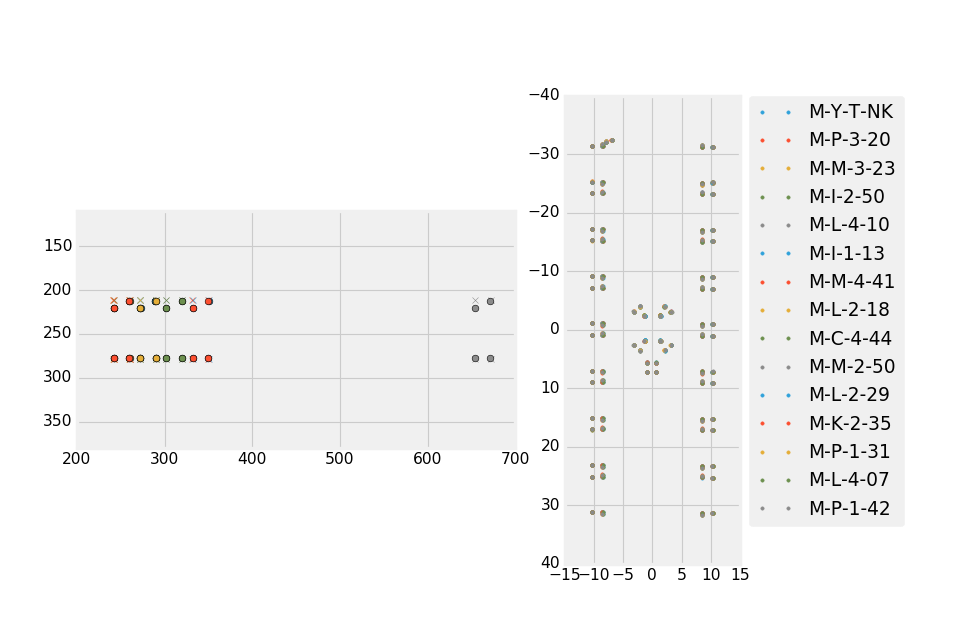

In [5]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1,.7]) 
ax_fid = fig.add_subplot(gs[0], adjustable='box', aspect=1)
ax_pot = fig.add_subplot(gs[1], adjustable='box', aspect=1)
for color, module_id in zip(plt_cols,list(modules.keys())[-15:]):
    module = modules[module_id]
    pts_local = []
    for val in module['pot_lines'].values():
        pts_local.append(val['local']['start'])
        pts_local.append(val['local']['end'])

    xs,ys,zs = zip(*pts_local)
    ax_pot.plot(xs,ys, '.', label=module_id, color=color)
    pts_local.clear()
    for val in module['BBM_fids'].values():
        pts_local.append(val['fid_pos'])
    xs,ys,zs = zip(*pts_local)
    ax_fid.plot(xs,ys, 'x', label=module_id, color=color)
    pts_local.clear()
    for val in module['HDI_fids'].values():
        pts_local.append(val['fid_pos'])
    xs,ys,zs = zip(*pts_local)
    ax_fid.plot(xs,ys, 'o', label=module_id, color=color)
ax_fid.set_ylim((380,110))
ax_pot.set_ylim((40,-40))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

<IPython.core.display.Javascript object>


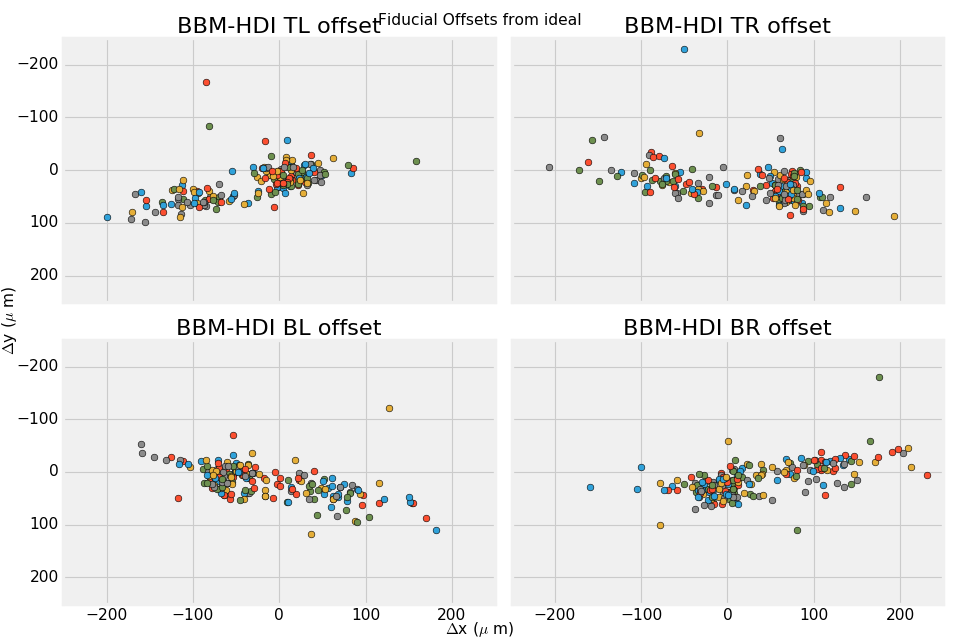

In [6]:
fig, ((ax_tl,ax_tr),(ax_bl,ax_br)) = plt.subplots(nrows=2, ncols=2,
                                                  sharex=True, sharey=True)
ideals = {'fid_TR': [-.39375, .9932, 0],
          'fid_TL': [ .39375,9.0921, 0],
          'fid_BL': [ .39375,-.9932, 0],
          'fid_BR': [-.39375,-.9932, 0]}
fids = ['fid_TR', 'fid_TL', 'fid_BL', 'fid_BR']
for fid, ax in zip(fids, [ax_tr, ax_tl, ax_bl, ax_br]):
    for color, module_id in zip(plt_cols,modules):
        module = modules[module_id]
        lb = module['BBM_fids'][fid]['fid_pos']
        lh = module['HDI_fids'][fid]['fid_pos']
        ideal = ideals[fid]
        delta = [(float(dh)-float(db)-idl)*1000 for db, dh, idl in zip(lb, lh, ideal)]
        ax.plot([delta[0]], [delta[1]], 'o', color=color, label=module_id)
    ax.set_title('BBM-HDI '+fid.split('_')[1]+' offset')
    ax.set_xlim((-250,250))
    ax.set_ylim((250,-250))
        
fig.suptitle('Fiducial Offsets from ideal')

fig.text(0.5, 0.01, '$\Delta$x ($\mu$ m)', ha='center')
fig.text(0.0, 0.5, '$\Delta$y ($\mu$ m)', va='center', rotation='vertical')   
fig.tight_layout()
plt.show()

In [7]:
def before(modules, date_str):
    cut_date = datetime.strptime(date_str,'%d/%m/%Y')
    for module_id, module in modules.items():
        pot_date = datetime.strptime(module['date'],'%d/%m/%Y')
        if pot_date < cut_date:
            yield module_id, module
def after(modules, date_str):
    cut_date = datetime.strptime(date_str,'%d/%m/%Y')
    for module_id, module in modules.items():
        pot_date = datetime.strptime(module['date'],'%d/%m/%Y')
        if pot_date >= cut_date:
            yield module_id, module


<IPython.core.display.Javascript object>


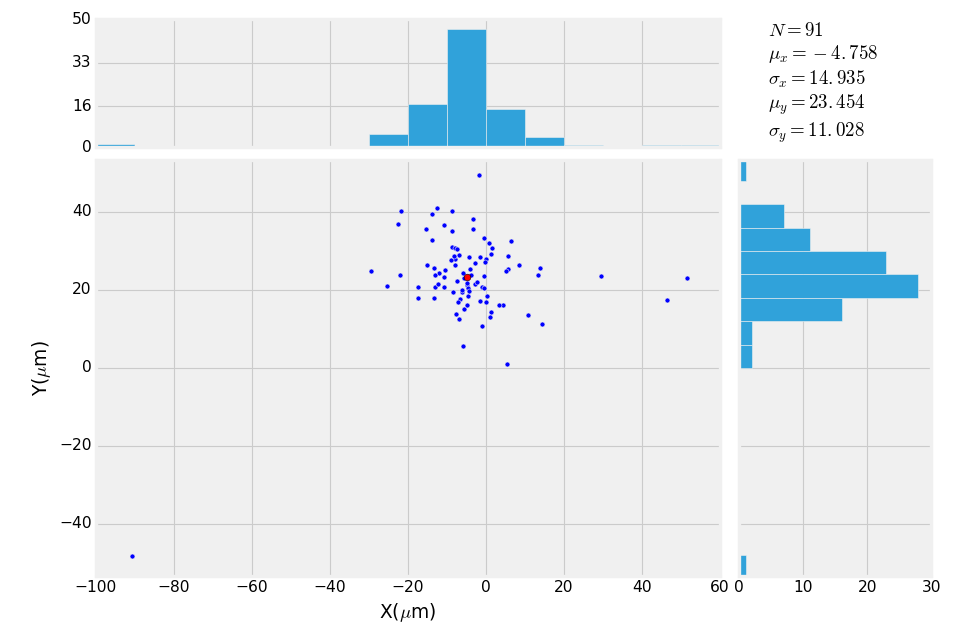

<IPython.core.display.Javascript object>


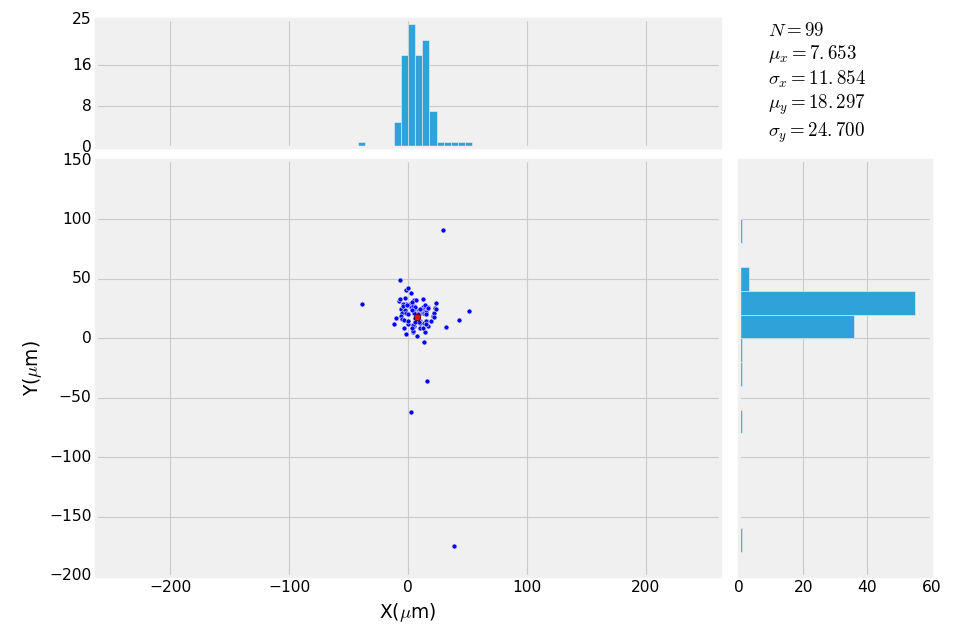

In [8]:
from scatter_hist import scatter_hist
def plot_offset(fig, modules):
    xs = []
    ys = []
    for module_id, module in modules:
        bbm_center = [float(x)*1000 for x in module['BBM_center']]
        hdi_center = [float(x)*1000 for x in module['HDI_center']]
        xs.append(hdi_center[0] - bbm_center[0])
        ys.append(hdi_center[1] - bbm_center[1])
    scatter_hist(xs, ys, fig, nbins=20, plot_mean=True, xlabel="X($\\mu$m)", ylabel="Y($\\mu$m)")
fixdate = '09/05/2016'
fig = plt.figure()
plot_offset(fig, before(modules, fixdate))
fig = plt.figure()
plot_offset(fig, after(modules, fixdate))

<IPython.core.display.Javascript object>


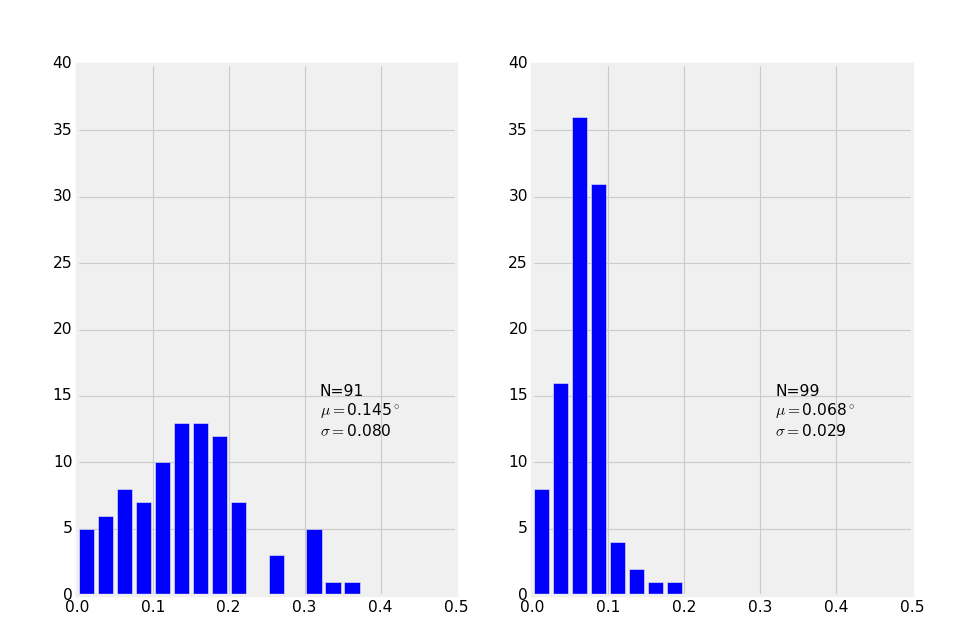

In [9]:
fig, (ax_pre, ax_post) = plt.subplots(nrows=1, ncols=2)
def histo2(ax, modules):
    data = []
    for module_id, module in modules:
        rot_bbm = net_phi(module['BBM_orient'])
        rot_hdi = net_phi(module['HDI_orient'])
        data.append(abs(rot_bbm - rot_hdi))
    hist, bins = np.histogram(data, bins=20, range=(0,.5))
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist, align='center', width=width)
    ax.set_xlim((0,.5))
    ax.set_ylim((0,40))
    label = "N={:d}\n$\mu=${:0.3f}$^\circ$\n$\sigma=${:0.3f}".format(len(data), np.mean(data), np.std(data))
    ax.text(0.32, 12, label)

histo2(ax_pre, before(modules, fixdate))
histo2(ax_post, after(modules, fixdate))
plt.show()

<IPython.core.display.Javascript object>


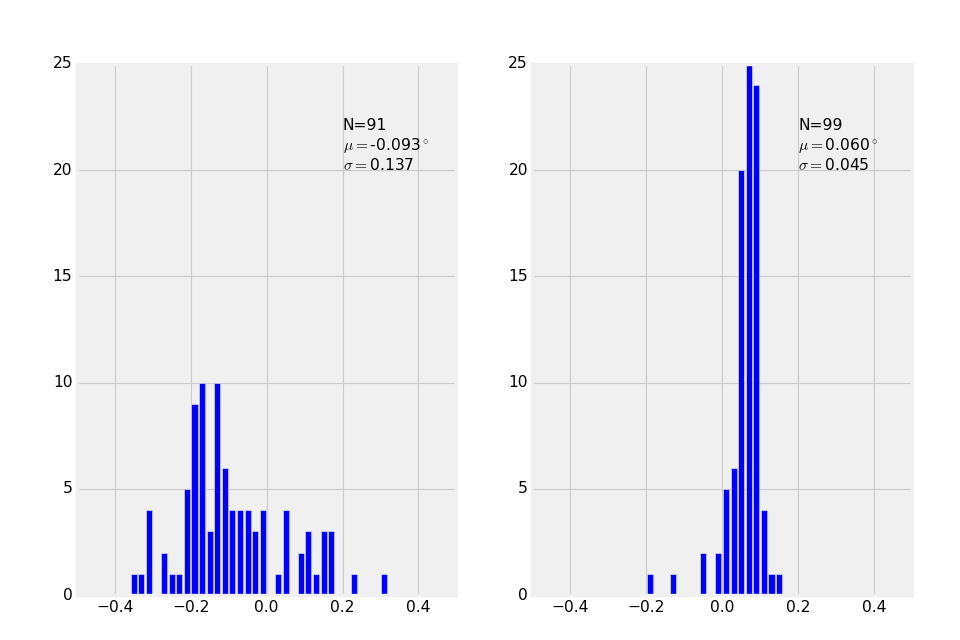

In [10]:
fig, (ax_pre, ax_post) = plt.subplots(nrows=1, ncols=2)
def histo2(ax, modules):
    data = []
    for module_id, module in modules:
        rot_bbm = net_phi(module['BBM_orient'])
        rot_hdi = net_phi(module['HDI_orient'])
        data.append(rot_hdi - rot_bbm)
    hist, bins = np.histogram(data, bins=50, range=(-.5,.5))
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist, align='center', width=width)
    ax.set_xlim((-.5,.5))
    ax.set_ylim((0,25))
    label = "N={:d}\n$\mu=${:0.3f}$^\circ$\n$\sigma=${:0.3f}".format(len(data), np.mean(data), np.std(data))
    ax.text(0.2, 20, label)

histo2(ax_pre, before(modules, fixdate))
histo2(ax_post, after(modules, fixdate))
plt.show()

<IPython.core.display.Javascript object>


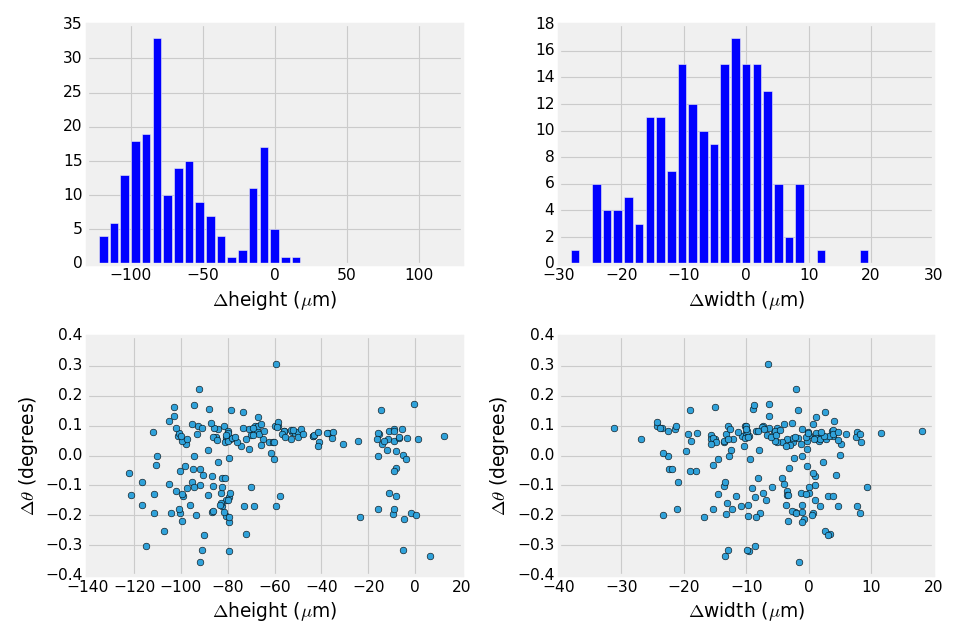

In [11]:
fig, ((ax_h, ax_w), (ax_rh, ax_rw)) = plt.subplots(nrows=2, ncols=2)
ideal_width = 18410.00  # μm
ideal_height = 60869.95  # μm , actually average between left and right spacings(left is smaller)
heights = []
widths = []
rots = []
for module in modules.values():
    fids = module['HDI_fids']
    fid_tr = fids['fid_TR']['fid_pos']
    fid_tl = fids['fid_TL']['fid_pos']
    fid_bl = fids['fid_BL']['fid_pos']
    fid_br = fids['fid_BR']['fid_pos']
    def dist(fid1, fid2):
        pairs = [(float(x), float(y)) for x,y in zip(fid1, fid2)]
        return np.sqrt(sum((x-y)**2 for x, y in pairs[:2]))*1000
    left_height = dist(fid_bl, fid_tl)
    right_height = dist(fid_br, fid_tr)
#     print("left height:{}\tright height:{}".format(left_height, right_height))
    height = (left_height+right_height)/2 - ideal_height
    heights.append(height)
    top_width = dist(fid_tl, fid_tr)
    bottom_width = dist(fid_bl, fid_br)
    width = (top_width+bottom_width)/2 - ideal_width
    widths.append(width)
    rot_bbm = net_phi(module['BBM_orient'])
    rot_hdi = net_phi(module['HDI_orient'])
    rots.append(rot_hdi - rot_bbm)
#     if(abs(height) < 40):
#         print("{:10} - {:+.03f}".format(module['id'], height))
    
def histo(data, ax, xlabel, nbins, range_):
    hist, bins = np.histogram(data, bins=nbins, range=range_)
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist, align='center', width=width)
    ax.set_xlabel(xlabel)
    ax.set_xlim(range_)
    
histo(heights, ax_h, '$\Delta$height ($\mu$m)', 35, (-130,130))
histo(widths, ax_w, '$\Delta$width ($\mu$m)', 35, (-30,30))

ax_rh.plot(heights, rots, 'o')
ax_rh.set_xlabel('$\Delta$height ($\mu$m)')
ax_rh.set_ylabel('$\Delta\\theta$ (degrees)')
ax_rw.plot(widths, rots, 'o')
ax_rw.set_xlabel('$\Delta$width ($\mu$m)')
ax_rw.set_ylabel('$\Delta\\theta$ (degrees)')
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


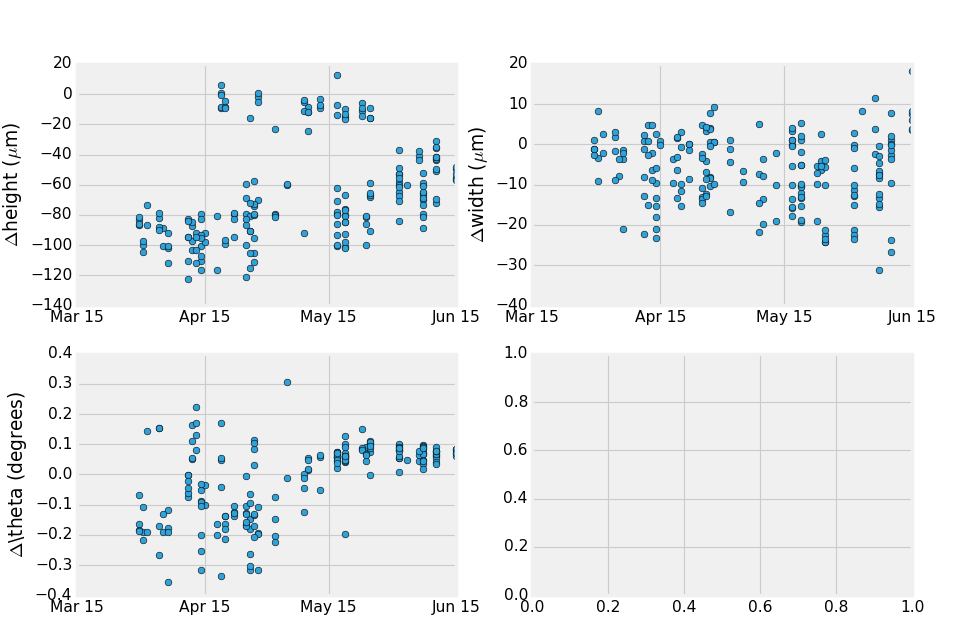

In [12]:
figure, ((ax_h, ax_w), (ax_r, _)) = plt.subplots(nrows=2, ncols=2)
times = []
for module in modules.values():
    date = module['date']
    times.append(datetime.strptime(date, '%d/%m/%Y'))
xticks = [datetime(2016, i, 15) for i in range(3,7)]
xticklabels = [d.strftime("%b %d") for d in xticks]

ax_h.plot(times, heights, 'o')
ax_h.set_xticks(xticks)
ax_h.set_xticklabels(xticklabels)
ax_h.set_ylabel('$\Delta$height ($\mu$m)')

ax_w.plot(times, widths, 'o')
ax_w.set_xticks(xticks)
ax_w.set_xticklabels(xticklabels)
ax_w.set_ylabel('$\Delta$width ($\mu$m)')

ax_r.plot(times, rots, 'o')
ax_r.set_xticks(xticks); ax_r.set_xticklabels(xticklabels)
ax_r.set_ylabel('$\Delta$\\theta (degrees)')
fig.tight_layout()

<IPython.core.display.Javascript object>


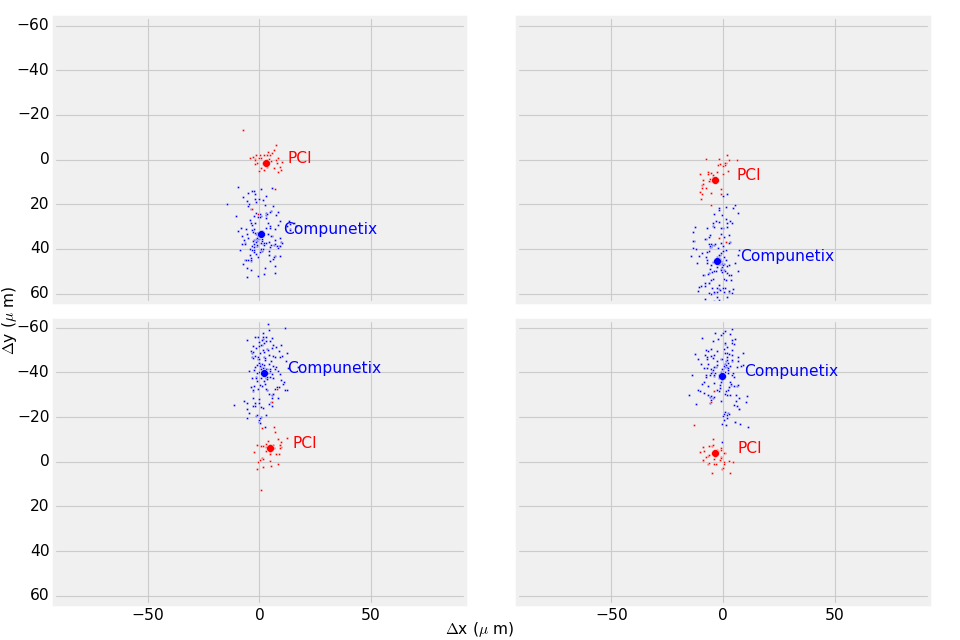

In [13]:
ideal_fids = {'fid_TL': np.array([-8759.5, -24359.9, 0]),
              'fid_TR': np.array([+8759.5, -32459.5, 0]),
              'fid_BL': np.array([-8759.5, +32459.5, 0]),
              'fid_BR': np.array([+8759.5, +32459.5, 0])}
def to_local_coords(center, orient, pos):
    center = np.array([float(d) for d in center])
    orient = Quaternion.Quat([float(d) for d in orient])
    pos = np.array([float(d) for d in pos])
    return orient.inv().transform @ (pos - center)

def get_fid_xy(module, fid):
    center = module['HDI_center']
    orient = module['HDI_orient']
    pos = module['HDI_fids'][fid]['fid_pos']
    local_pos = 1000*to_local_coords(center, orient, pos)
    return (local_pos - ideal_fids[fid])[:2]

def is_numeric(number):
    try:
        int(number)
        return True
    except ValueError:
        return False

fids_comp = []
fids_pci = []

for module_id, module in modules.items():
    tl = get_fid_xy(module, 'fid_TL')
    tr = get_fid_xy(module, 'fid_TR')
    bl = get_fid_xy(module, 'fid_BL')
    br = get_fid_xy(module, 'fid_BR')
    if is_numeric(module_id[-2:]):
        fids_comp.append((tl, tr, bl, br))
    else:
        fids_pci.append((tl, tr, bl, br))
        
figure, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
axs = list(itertools.chain(*axs))


for ax, comp, pci in zip(axs, zip(*fids_comp), zip(*fids_pci)):
    xs, ys = zip(*comp)
    comp_mean = np.array((np.mean(xs), np.mean(ys)))
    ax.scatter(xs, ys, c='b', s=20, marker='.')
    ax.scatter([comp_mean[0]], [comp_mean[1]], c='b', s=50)
    ax.text(comp_mean[0]+10, comp_mean[1], 'Compunetix', color='b')
    
    xs, ys = zip(*pci)
    pci_mean = np.array((np.mean(xs), np.mean(ys)))
    ax.scatter(xs, ys, c='r', s=20, marker='.')
    ax.scatter([pci_mean[0]], [pci_mean[1]], c='r', s=50)
    ax.text(pci_mean[0]+10, pci_mean[1], 'PCI', color='r')
    
    plot_center = (comp_mean + pci_mean) / 2
#     ax.set_xlim((plot_center[0]-60,plot_center[0]+60))
#     ax.set_ylim((plot_center[1]+40,plot_center[1]-40))
    ax.set_xlim((-100,100))
    ax.set_ylim((100,-100))
    
    ax.set_aspect('equal')

figure.text(0.5, 0.01, '$\Delta$x ($\mu$ m)', ha='center')
figure.text(0.0, 0.5, '$\Delta$y ($\mu$ m)', va='center', rotation='vertical')   
figure.tight_layout()